

## *Section 2 Project - S2P : Machine Learning*

# "From Iron, Diamond to Challenger"
**Analyzing game pattern in League of Legends**

(도현진)

August 31th, 2021

---

In [285]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from ipywidgets import interact, fixed
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import xgboost
import eli5
import shap
import warnings

In [366]:
lol_df = pd.read_csv('/Users/doguma/Documents/GitHub/lol_gamedata.csv')

In [367]:
champ_info1 = pd.read_json('/Users/doguma/Documents/GitHub/champion_info_2.json')
champ_info2 = pd.read_json('/Users/doguma/Documents/GitHub/champion_info.json')

In [369]:
summoner_spell = pd.read_json('/Users/doguma/Documents/GitHub/summoner_spell_info.json')

In [106]:
lol_df.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In [82]:
champ_info1.head()

,type,version,data
Aatrox,champion,7.18.1,"{'tags': ['Fighter', 'Tank'], 'title': 'the Da..."
Ahri,champion,7.18.1,"{'tags': ['Mage', 'Assassin'], 'title': 'the N..."
Akali,champion,7.18.1,"{'tags': ['Assassin'], 'title': 'the Fist of S..."
Alistar,champion,7.18.1,"{'tags': ['Tank', 'Support'], 'title': 'the Mi..."
Amumu,champion,7.18.1,"{'tags': ['Tank', 'Mage'], 'title': 'the Sad M..."


In [107]:
champ_info1['data'][0]

{'tags': ['Fighter', 'Tank'],
 'title': 'the Darkin Blade',
 'id': 266,
 'key': 'Aatrox',
 'name': 'Aatrox'}

In [370]:
champ_info1 = pd.read_json((champ_info1['data']).to_json(), \
                           orient='index')

In [371]:
champ_info1.head()

,tags,title,id,key,name
Aatrox,"[Fighter, Tank]",the Darkin Blade,266,Aatrox,Aatrox
Ahri,"[Mage, Assassin]",the Nine-Tailed Fox,103,Ahri,Ahri
Akali,[Assassin],the Fist of Shadow,84,Akali,Akali
Alistar,"[Tank, Support]",the Minotaur,12,Alistar,Alistar
Amumu,"[Tank, Mage]",the Sad Mummy,32,Amumu,Amumu


In [372]:
champ_info2['data'][266]

{'title': 'the Darkin Blade', 'id': 266, 'key': 'Aatrox', 'name': 'Aatrox'}

In [373]:
champ_info2 = pd.read_json((champ_info2['data']).to_json(), \
                           orient='index')

In [374]:
champ_info2.head()

,title,id,key,name
1,the Dark Child,1,Annie,Annie
10,The Judicator,10,Kayle,Kayle
101,the Magus Ascendant,101,Xerath,Xerath
102,the Half-Dragon,102,Shyvana,Shyvana
103,the Nine-Tailed Fox,103,Ahri,Ahri


In [375]:
merged_info = champ_info1.merge(champ_info2, on=['id'])
merged_info.drop(['title_x', 'key_x','name_y', 'key_y'], axis=1, inplace=True)

merged_info.rename(columns={'name_x': 'name', 'title_y': 'title' }, inplace=True)
merged_info


,tags,id,name,title
0,"[Fighter, Tank]",266,Aatrox,the Darkin Blade
1,"[Mage, Assassin]",103,Ahri,the Nine-Tailed Fox
2,[Assassin],84,Akali,the Fist of Shadow
3,"[Tank, Support]",12,Alistar,the Minotaur
4,"[Tank, Mage]",32,Amumu,the Sad Mummy
...,...,...,...,...
133,"[Tank, Fighter]",154,Zac,the Secret Weapon
134,"[Assassin, Fighter]",238,Zed,the Master of Shadows
135,[Mage],115,Ziggs,the Hexplosives Expert
136,"[Support, Mage]",26,Zilean,the Chronokeeper


In [376]:
merged_info = merged_info.set_index('id')

In [377]:
merged_info = merged_info.sort_index()
merged_info.head()

,tags,name,title
id,,,
1,[Mage],Annie,the Dark Child
2,"[Fighter, Tank]",Olaf,the Berserker
3,"[Tank, Mage]",Galio,the Colossus
4,[Mage],Twisted Fate,the Card Master
5,"[Fighter, Assassin]",Xin Zhao,the Seneschal of Demacia


In [378]:
lol_df['t1_champ1tags'] = ''
lol_df['t1_champ2tags'] = ''
lol_df['t1_champ3tags'] = ''
lol_df['t1_champ4tags'] = ''
lol_df['t1_champ5tags'] = ''

lol_df['t2_champ1tags'] = ''
lol_df['t2_champ2tags'] = ''
lol_df['t2_champ3tags'] = ''
lol_df['t2_champ4tags'] = ''
lol_df['t2_champ5tags'] = ''

In [379]:
def addTags(i):
    return merged_info['tags'][i]

In [380]:
tags_t1 = ['t1_tank', 't1_fighter', 't1_assassin', 't1_mage', \
        't1_support', 't1_marksman']
tags_t2 = ['t2_tank', 't2_fighter', 't2_assassin', 't2_mage', \
        't2_support', 't2_marksman']

t1_id = ['t1_champ1id', 't1_champ2id', 't1_champ3id, ', 't1_champ4id', 't1_champ5id']
t2_id = ['t2_champ1id', 't2_champ2id', 't2_champ3id, ', 't2_champ4id', 't2_champ5id']


tags = lol_df['t1_champ1id'].apply(addTags)
lol_df['t1_champ1tags'] = tags
tags = lol_df['t1_champ2id'].apply(addTags)
lol_df['t1_champ2tags'] = tags
tags = lol_df['t1_champ3id'].apply(addTags)
lol_df['t1_champ3tags'] = tags
tags = lol_df['t1_champ4id'].apply(addTags)
lol_df['t1_champ4tags'] = tags
tags = lol_df['t1_champ5id'].apply(addTags)
lol_df['t1_champ5tags'] = tags


tags = lol_df['t2_champ1id'].apply(addTags)
lol_df['t2_champ1tags'] = tags
tags = lol_df['t2_champ2id'].apply(addTags)
lol_df['t2_champ2tags'] = tags
tags = lol_df['t2_champ3id'].apply(addTags)
lol_df['t2_champ3tags'] = tags
tags = lol_df['t2_champ4id'].apply(addTags)
lol_df['t2_champ4tags'] = tags
tags = lol_df['t2_champ5id'].apply(addTags)
lol_df['t2_champ5tags'] = tags

In [381]:
lol_df

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t1_champ1tags,t1_champ2tags,t1_champ3tags,t1_champ4tags,t1_champ5tags,t2_champ1tags,t2_champ2tags,t2_champ3tags,t2_champ4tags,t2_champ5tags
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,"[Mage, Tank]","[Support, Mage]","[Marksman, Mage]","[Assassin, Fighter]",[Mage],[Marksman],[Marksman],"[Fighter, Tank]","[Assassin, Fighter]","[Support, Fighter]"
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,[Marksman],"[Fighter, Assassin]","[Assassin, Fighter]","[Fighter, Support]",[Assassin],"[Tank, Fighter]","[Mage, Support]","[Fighter, Tank]","[Fighter, Assassin]","[Fighter, Assassin]"
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,"[Marksman, Assassin]","[Fighter, Assassin]","[Support, Mage]","[Fighter, Mage]","[Assassin, Mage]",[Mage],"[Support, Fighter]","[Fighter, Marksman]","[Fighter, Assassin]","[Marksman, Support]"
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,"[Tank, Mage]",[Mage],"[Marksman, Assassin]","[Mage, Support]","[Fighter, Tank]","[Mage, Assassin]","[Fighter, Tank]","[Support, Fighter]","[Fighter, Assassin]","[Marksman, Support]"
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,"[Fighter, Tank]","[Marksman, Assassin]","[Support, Mage]",[Marksman],"[Mage, Support]","[Support, Mage]","[Tank, Fighter]","[Fighter, Assassin]","[Assassin, Mage]",[Marksman]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,"[Fighter, Tank]",[Marksman],"[Assassin, Fighter]","[Support, Mage]","[Fighter, Assassin]",[Mage],"[Fighter, Tank]","[Marksman, Assassin]","[Support, Mage]","[Fighter, Mage]"
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,"[Mage, Assassin]","[Tank, Mage]","[Tank, Mage]","[Support, Fighter]","[Marksman, Assassin]","[Fighter, Tank]",[Marksman],"[Tank, Support]","[Fighter, Tank]",[Mage]
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,"[Fighter, Assassin]","[Marksman, Assassin]","[Support, Mage]","[Marksman, Mage]","[Fighter, Mage]",[Mage],[Marksman],"[Tank, Fighter]","[Mage, Support]","[Mage, Support]"
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,"[Assassin, Fighter]",[Marksman],"[Fighter, Tank]","[Support, Tank]","[Mage, Support]",[Marksman],"[Assassin, Fighter]","[Mage, Support]",[Mage],"[Assassin, Fighter]"


In [384]:
tags_df = pd.DataFrame()

In [391]:
lol_df['t1_tags'] = lol_df['t1_champ1tags'] + lol_df['t1_champ2tags']\
                + lol_df['t1_champ3tags'] + lol_df['t1_champ4tags']\
                + lol_df['t1_champ5tags']
tags_df['t1'] = lol_df['t1_tags']
lol_df['t1_tags'][0]

['Mage',
 'Tank',
 'Support',
 'Mage',
 'Marksman',
 'Mage',
 'Assassin',
 'Fighter',
 'Mage']

In [392]:
lol_df['t2_tags'] = lol_df['t2_champ1tags'] + lol_df['t2_champ2tags']\
                + lol_df['t2_champ3tags'] + lol_df['t2_champ4tags']\
                + lol_df['t2_champ5tags']
tags_df['t2'] = lol_df['t2_tags']
lol_df['t2_tags'][0]

['Marksman',
 'Marksman',
 'Fighter',
 'Tank',
 'Assassin',
 'Fighter',
 'Support',
 'Fighter']

In [132]:
# tags_t1 = ['t1_tank', 't1_fighter', 't1_assassin', 't1_mage', \
#         't1_support', 't1_marksman']
# tags_t2 = ['t2_tank', 't2_fighter', 't2_assassin', 't2_mage', \
#         't2_support', 't2_marksman']

# Creating separate columns for each Tag Type

lol_df['t1_tank'] = 0
lol_df['t1_fighter'] = 0
lol_df['t1_assassin'] = 0
lol_df['t1_mage'] = 0
lol_df['t1_support'] = 0
lol_df['t1_marksman'] = 0

lol_df['t2_tank'] = 0
lol_df['t2_fighter'] = 0
lol_df['t2_assassin'] = 0
lol_df['t2_mage'] = 0
lol_df['t2_support'] = 0
lol_df['t2_marksman'] = 0

for i in range(len(lol_df)):
    for j in lol_df['t1_tags'][i]:
        if j == 'Tank':
            lol_df['t1_tank'][i] += 1
        elif j == 'Fighter':
            lol_df['t1_fighter'][i] += 1
        elif j == 'Assassin':
            lol_df['t1_assassin'][i] += 1
        elif j == 'Mage':
            lol_df['t1_mage'][i] += 1
        elif j == 'Support':
            lol_df['t1_support'][i] += 1    
        elif j == 'Marskman':
            lol_df['t1_marksman'][i] += 1
        else:
            pass


In [134]:
for i in range(len(lol_df)):
    for j in lol_df['t2_tags'][i]:
        if j == 'Tank':
            lol_df['t2_tank'][i] += 1
        elif j == 'Fighter':
            lol_df['t2_fighter'][i] += 1
        elif j == 'Assassin':
            lol_df['t2_assassin'][i] += 1
        elif j == 'Mage':
            lol_df['t2_mage'][i] += 1
        elif j == 'Support':
            lol_df['t2_support'][i] += 1    
        elif j == 'Marskman':
            lol_df['t2_marksman'][i] += 1
        else:
            pass

In [137]:
# dropping redundant columns now that the new features have been created

lol_df.drop(['t1_tags', 't2_tags', 't1_champ1tags', 't1_champ2tags',\
            't1_champ3tags', 't1_champ4tags', 't1_champ5tags',\
            't2_champ1tags', 't2_champ2tags', 't2_champ3tags',\
            't2_champ4tags', 't2_champ5tags'], axis=1, inplace=True)

# dropping additional columns (bans) that may not be useful for ML model

lol_df.drop(['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4',\
            't1_ban5', 't2_ban1', 't2_ban2',\
            't2_ban3', 't2_ban4', 't2_ban5',\
            'gameId', 'creationTime', 'seasonId'], axis=1, inplace=True)

In [165]:
lol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gameDuration        51490 non-null  int64
 1   winner              51490 non-null  int64
 2   firstBlood          51490 non-null  int64
 3   firstTower          51490 non-null  int64
 4   firstInhibitor      51490 non-null  int64
 5   firstBaron          51490 non-null  int64
 6   firstDragon         51490 non-null  int64
 7   firstRiftHerald     51490 non-null  int64
 8   t1_champ1id         51490 non-null  int64
 9   t1_champ1_sum1      51490 non-null  int64
 10  t1_champ1_sum2      51490 non-null  int64
 11  t1_champ2id         51490 non-null  int64
 12  t1_champ2_sum1      51490 non-null  int64
 13  t1_champ2_sum2      51490 non-null  int64
 14  t1_champ3id         51490 non-null  int64
 15  t1_champ3_sum1      51490 non-null  int64
 16  t1_champ3_sum2      51490 non-null  int6

In [440]:
# summoner spells df created for later analysis

summoner_spell_df = pd.read_json((summoner_spell['data'])\
                               .to_json(), orient='index').set_index('id').sort_index()
summoner_spell_df.head()

,summonerLevel,name,key,description
id,,,,
1,6,Cleanse,SummonerBoost,Removes all disables (excluding suppression an...
3,4,Exhaust,SummonerExhaust,"Exhausts target enemy champion, reducing their..."
4,8,Flash,SummonerFlash,Teleports your champion a short distance towar...
6,1,Ghost,SummonerHaste,Your champion gains increased Movement Speed a...
7,1,Heal,SummonerHeal,Restores 90-345 Health (depending on champion ...


## League of Legends Ranked Games 
### Mitchell J / Kaggle (2017) 

Collection of over 50,000 ranked EUW games from the game League of Legends, as well as json files containing a way to convert between champion and summoner spell IDs and their names. For each game, there are fields for:

- Game ID
- Creation Time (in Epoch format)
- Game Duration (in seconds)
- Season ID
- Winner (1 = team1, 2 = team2)
- First Baron, dragon, tower, blood, inhibitor and Rift Herald (1 = team1, 2 = team2, 0 = none)
- Champions and summoner spells for each team (Stored as Riot's champion and summoner spell IDs)
- The number of tower, inhibitor, Baron, dragon and Rift Herald kills each team has
- The 5 bans of each team (Again, champion IDs are used)

https://www.kaggle.com/datasnaek/league-of-legends?select=games.csv

[Text(0.5, 0, 'Team Name (1 or 2)'), Text(0, 0.5, '# of instances')]

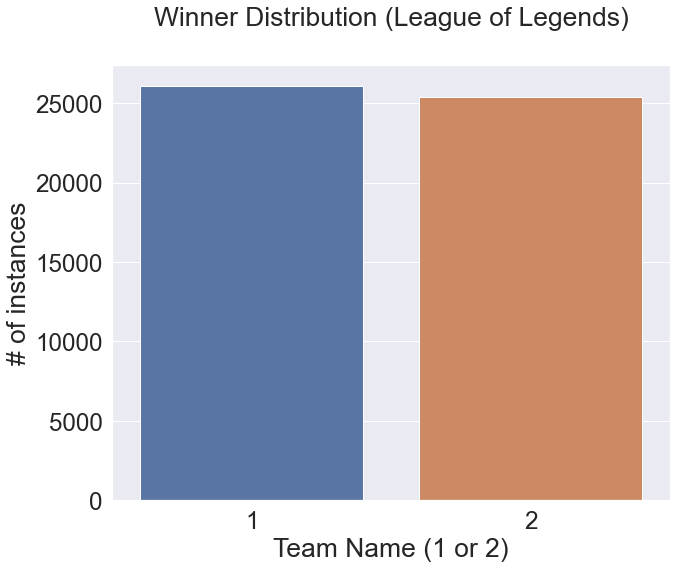

In [14]:
sns.set(font_scale=2.2)

plt.figure(figsize=(10,8))
ax = sns.countplot(lol_df['winner'])
ax.set_title('Winner Distribution (League of Legends)', pad=40)
ax.set(xlabel='Team Name (1 or 2)', ylabel='# of instances')


In [141]:
y = lol_df['winner']
X = lol_df.drop(['winner'], axis=1)

In [142]:
X['t2_riftHeraldKills'].value_counts()

0    39127
1    12363
Name: t2_riftHeraldKills, dtype: int64

[Text(1, 0, 'Champion1 SummonerSpell1'),
 Text(2, 0, 'Team 2 Tower Kills'),
 Text(3, 0, 'Team 2 Dragon Kills'),
 Text(4, 0, 'Team 2 Baron Kills')]

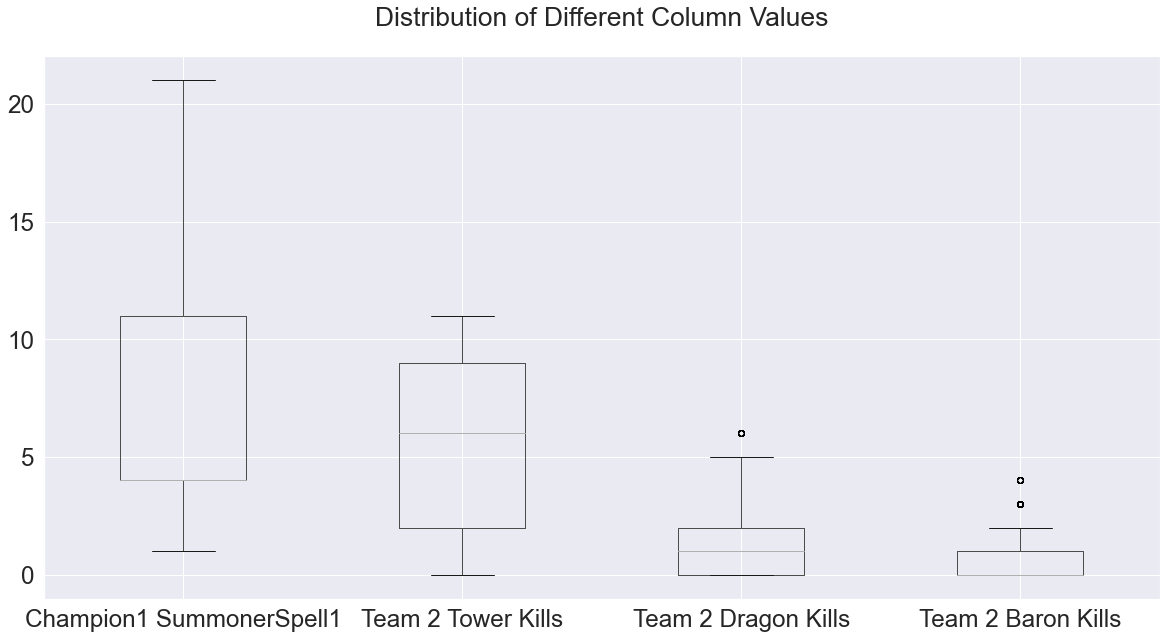

In [32]:
data2 = X[['t2_champ1_sum1', 't2_towerKills', 't2_dragonKills', 't2_baronKills']]

axes = data2.boxplot(figsize=(20, 10))
title_boxplot = 'Distribution of Different Column Values'
plt.title( title_boxplot, pad =30)
axes.set_xticklabels(['Champion1 SummonerSpell1', 'Team 2 Tower Kills', 'Team 2 Dragon Kills', 'Team 2 Baron Kills'])


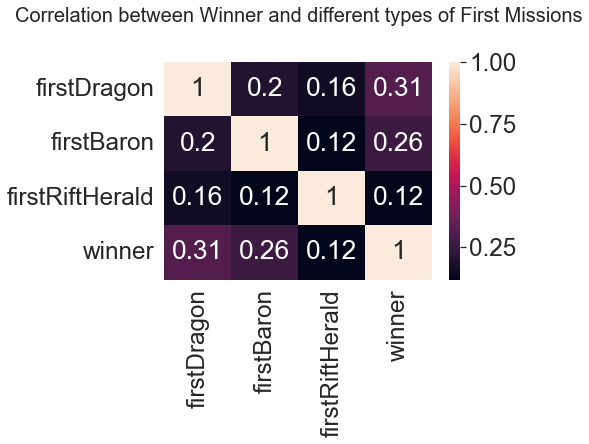

<Figure size 1440x1080 with 0 Axes>

In [18]:
plt.title('Correlation between Winner and different types of First Missions', pad=40, size=20)
sns.heatmap(lol_df[["firstDragon","firstBaron","firstRiftHerald","winner"]].corr(),annot = True)
plt.figure(figsize=(20,15))

plt.show()

In [303]:
X_train, X_val, y_train, y_val = train_test_split(X, y, \
                                    train_size=0.8, random_state=2)

In [144]:
pipe = make_pipeline(
    LogisticRegression()
)

In [145]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('logisticregression', LogisticRegression())])

In [146]:
y_pred = pipe.predict(X_val)

In [147]:
print('검증 정확도', pipe.score(X_val, y_val))

검증 정확도 0.9570790444746553


In [148]:
len(y_pred), y_pred.sum()

(10298, 15423)

In [150]:
print('Logistic Regression Val Score: ', f1_score(y_val, y_pred), '\n')

print(classification_report(y_val, y_pred))

Logistic Regression Val Score:  0.9571705426356588 

              precision    recall  f1-score   support

           1       0.95      0.96      0.96      5147
           2       0.96      0.95      0.96      5151

    accuracy                           0.96     10298
   macro avg       0.96      0.96      0.96     10298
weighted avg       0.96      0.96      0.96     10298



In [11]:
# 단순한 logistic regression을 기준(Baseline) 모델로 선택

In [156]:
models = [
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]

# 다양한 모델들로 데이터셋을 사용해 성능 비교

In [162]:
results = []
names = []
dfs = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['team 1', 'team 2']

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(name)
    print(classification_report(y_val, y_pred, target_names=target_names))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
final

RF
              precision    recall  f1-score   support

      team 1       0.97      0.97      0.97      5147
      team 2       0.97      0.97      0.97      5151

    accuracy                           0.97     10298
   macro avg       0.97      0.97      0.97     10298
weighted avg       0.97      0.97      0.97     10298

KNN
              precision    recall  f1-score   support

      team 1       0.51      0.52      0.51      5147
      team 2       0.51      0.50      0.50      5151

    accuracy                           0.51     10298
   macro avg       0.51      0.51      0.51     10298
weighted avg       0.51      0.51      0.51     10298

SVM
              precision    recall  f1-score   support

      team 1       0.81      0.91      0.86      5147
      team 2       0.90      0.79      0.84      5151

    accuracy                           0.85     10298
   macro avg       0.85      0.85      0.85     10298
weighted avg       0.85      0.85      0.85     10298

GNB
    

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,3.098676,0.156745,0.969535,0.969538,0.969535,0.969534,0.997483,RF
1,3.188755,0.158979,0.968079,0.968079,0.968079,0.968078,0.996986,RF
2,3.082980,0.155371,0.968318,0.968322,0.968318,0.968318,0.997245,RF
3,2.755910,0.145808,0.969896,0.969963,0.969896,0.969894,0.997281,RF
4,2.853027,0.146643,0.969289,0.969291,0.969289,0.969288,0.997106,RF
5,0.011879,7.443417,0.504673,0.504534,0.504673,0.504584,0.506498,KNN
6,0.009058,7.948629,0.514868,0.515096,0.514868,0.514908,0.517657,KNN
7,0.007834,8.609264,0.510682,0.510771,0.510682,0.510721,0.512282,KNN
8,0.008655,7.869237,0.519422,0.519359,0.519422,0.519251,0.525996,KNN
9,0.007799,8.021669,0.512017,0.511937,0.512017,0.511886,0.513218,KNN


In [163]:
final

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,3.098676,0.156745,0.969535,0.969538,0.969535,0.969534,0.997483,RF
1,3.188755,0.158979,0.968079,0.968079,0.968079,0.968078,0.996986,RF
2,3.082980,0.155371,0.968318,0.968322,0.968318,0.968318,0.997245,RF
3,2.755910,0.145808,0.969896,0.969963,0.969896,0.969894,0.997281,RF
4,2.853027,0.146643,0.969289,0.969291,0.969289,0.969288,0.997106,RF
5,0.011879,7.443417,0.504673,0.504534,0.504673,0.504584,0.506498,KNN
6,0.009058,7.948629,0.514868,0.515096,0.514868,0.514908,0.517657,KNN
7,0.007834,8.609264,0.510682,0.510771,0.510682,0.510721,0.512282,KNN
8,0.008655,7.869237,0.519422,0.519359,0.519422,0.519251,0.525996,KNN
9,0.007799,8.021669,0.512017,0.511937,0.512017,0.511886,0.513218,KNN


[Text(0.5, 0, 'models'), Text(0, 0.5, 'AUC score')]

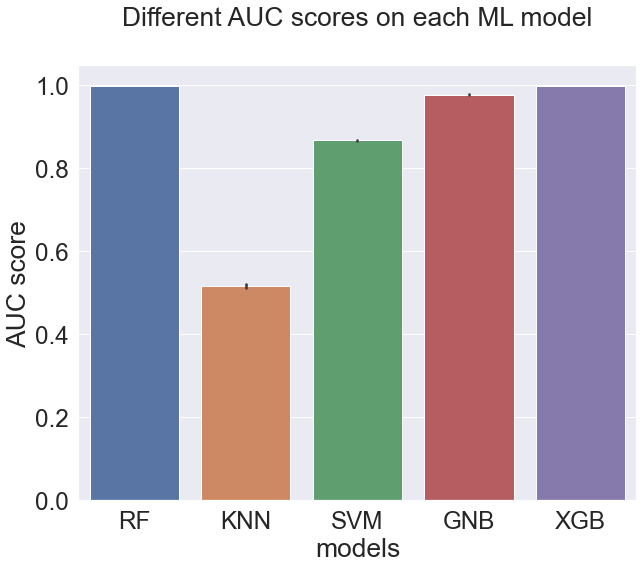

In [240]:
plt.figure(figsize=(10,8))
ax2 = sns.barplot(x="model", y="test_roc_auc", data=final)
ax2.set_title('Different AUC scores on each ML model', pad=40)
ax2.set(xlabel='models', ylabel='AUC score')

[Text(0.5, 0, 'models'), Text(0, 0.5, 'fit time')]

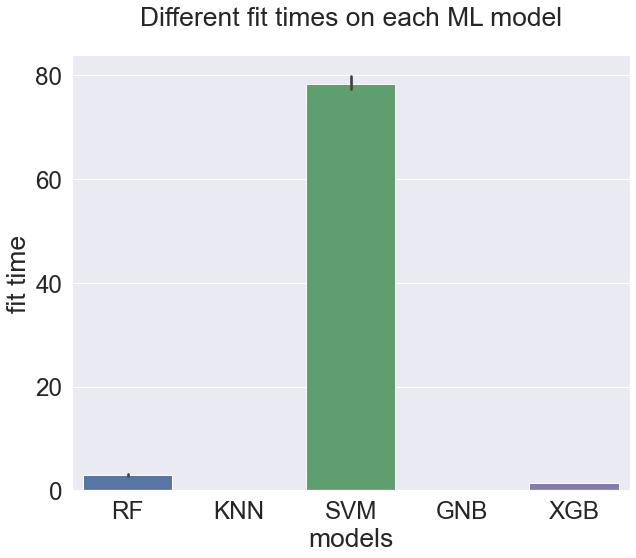

In [245]:
plt.figure(figsize=(10,8))
ax2 = sns.barplot(x="model", y="fit_time", data=final)
ax2.set_title('Different fit times on each ML model', pad=30)
ax2.set(xlabel='models', ylabel='fit time')

[Text(0.5, 0, 'models'), Text(0, 0.5, 'score time')]

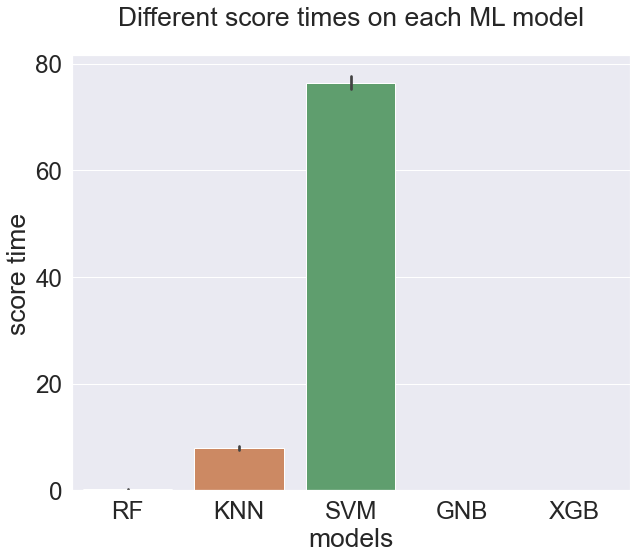

In [247]:
plt.figure(figsize=(10,8))
ax2 = sns.barplot(x="model", y="score_time", data=final)
ax2.set_title('Different score times on each ML model', pad=30)
ax2.set(xlabel='models', ylabel='score time')

---

In [180]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [181]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [190]:

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

# Here we go
random_search.fit(X, y)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[16:48:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:48:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7ff9c2fda430>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None, silent=True,
                                           subsa

In [191]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with \
%d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)



 All results:
{'mean_fit_time': array([30.22213833, 48.19588065, 44.64519827, 31.69332695, 41.77119597]), 'std_fit_time': array([0.13855488, 0.1439657 , 0.37447859, 0.34641353, 0.45962223]), 'mean_score_time': array([0.09444634, 0.17268173, 0.18268077, 0.17838407, 0.12785943]), 'std_score_time': array([0.00278327, 0.00937327, 0.00624767, 0.00408221, 0.01740586]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
         

In [202]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,30.222138,0.138555,0.094446,0.002783,1,5,3,5,1,"{'subsample': 1.0, 'min_child_weight': 5, 'max...",0.997349,0.997174,0.997484,0.997336,0.000127,5
1,48.195881,0.143966,0.172682,0.009373,0.6,1,5,1.5,0.8,"{'subsample': 0.6, 'min_child_weight': 1, 'max...",0.997540,0.997521,0.997673,0.997578,0.000068,3
2,44.645198,0.374479,0.182681,0.006248,0.8,5,5,1,0.8,"{'subsample': 0.8, 'min_child_weight': 5, 'max...",0.997568,0.997514,0.997715,0.997599,0.000085,2
3,31.693327,0.346414,0.178384,0.004082,1,5,5,5,0.6,"{'subsample': 1.0, 'min_child_weight': 5, 'max...",0.997554,0.997491,0.997759,0.997601,0.000115,1
4,41.771196,0.459622,0.127859,0.017406,0.8,1,4,1,1,"{'subsample': 0.8, 'min_child_weight': 1, 'max...",0.997511,0.997487,0.997689,0.997563,0.000090,4


In [210]:
result_sorted = results[['mean_fit_time', 'mean_score_time', 'param_subsample', 'param_min_child_weight',\
         'param_max_depth', 'param_gamma', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
result_sorted.columns = ['mean fit time', 'Mean score time', 'subsample', 'min child weight', 'max depth', 'gamma', 'mean test score', 'rank']

result_sorted

,mean fit time,Mean score time,subsample,min child weight,max depth,gamma,mean test score,rank
3,31.693327,0.178384,1,5,5,5,0.997601,1
2,44.645198,0.182681,0.8,5,5,1,0.997599,2
1,48.195881,0.172682,0.6,1,5,1.5,0.997578,3
4,41.771196,0.127859,0.8,1,4,1,0.997563,4
0,30.222138,0.094446,1,5,3,5,0.997336,5


In [196]:
# setting up new classifier
# based on previous hyperparameter tuning

xgb_final = XGBClassifier(colsample_bytree=0.6,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, gamma = 5,
              n_estimators=600, scale_pos_weight=1,verbosity=1)

In [198]:
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(xgb_final, X_train, y_train, cv=kfold, scoring=scoring)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print('XGB with tuned parameters')
print(classification_report(y_val, y_pred, target_names=target_names))

XGB with tuned parameters
              precision    recall  f1-score   support

      team 1       0.97      0.97      0.97      5147
      team 2       0.97      0.97      0.97      5151

    accuracy                           0.97     10298
   macro avg       0.97      0.97      0.97     10298
weighted avg       0.97      0.97      0.97     10298



In [31]:
! pip install eli5

In [216]:

# warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=5,
    random_state=2
)


permuter.fit(X_val, y_val);

In [217]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

t1_champ5_sum1       -2.759485e-05
t1_champ1_sum1       -2.378528e-05
t2_support           -1.934204e-05
t2_champ3_sum2       -9.414535e-06
t2_mage              -4.827967e-06
t2_fighter           -4.511131e-06
t2_champ5_sum2       -4.450782e-06
t2_champ1id          -2.323459e-06
t2_champ4_sum1       -2.002852e-06
t2_champ4_sum2       -2.112235e-07
t1_marksman           0.000000e+00
t2_riftHeraldKills    0.000000e+00
t2_marksman           0.000000e+00
t2_champ2_sum1        1.139098e-06
t2_champ5_sum1        1.950046e-06
t1_champ1_sum2        2.210303e-06
t2_champ4id           2.534682e-06
t1_support            2.666697e-06
t2_assassin           3.537994e-06
t1_champ3id           5.469181e-06
t1_riftHeraldKills    5.680404e-06
t1_champ4_sum1        6.962833e-06
t1_champ3_sum2        7.845446e-06
firstDragon           7.875620e-06
t1_tank               8.222631e-06
t1_champ2_sum1        8.509291e-06
t1_fighter            8.577184e-06
t2_tank               1.071959e-05
t2_champ3_sum1      

In [225]:
shap.initjs();

In [226]:
row = X_val.iloc[[1]]
row

,gameDuration,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,...,t1_assassin,t1_mage,t1_support,t1_marksman,t2_tank,t2_fighter,t2_assassin,t2_mage,t2_support,t2_marksman
17209,1637,1,1,1,1,1,1,33,4,12,...,1,2,1,0,1,1,1,4,1,0


In [228]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

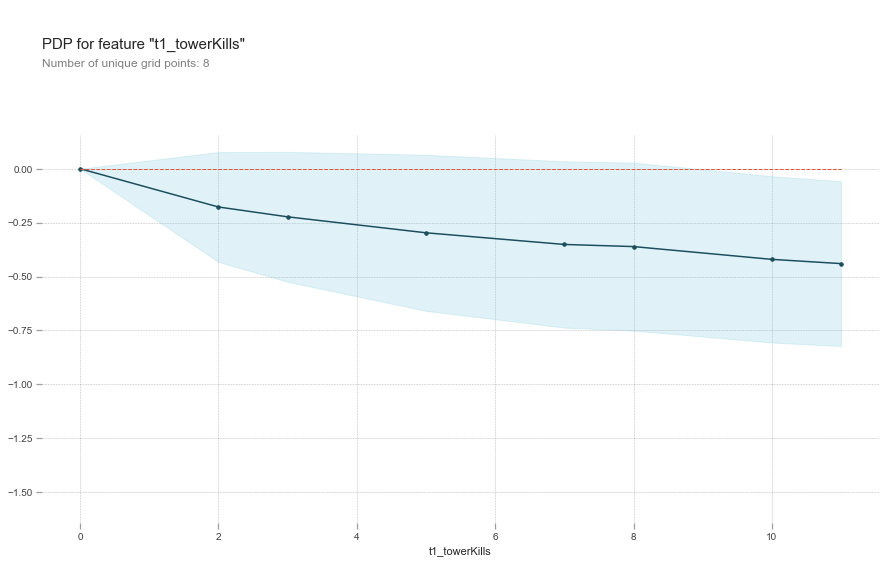

In [250]:

feature = 't1_towerKills'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points=10
)

pdp_plot(isolated, feature_name=feature);

---

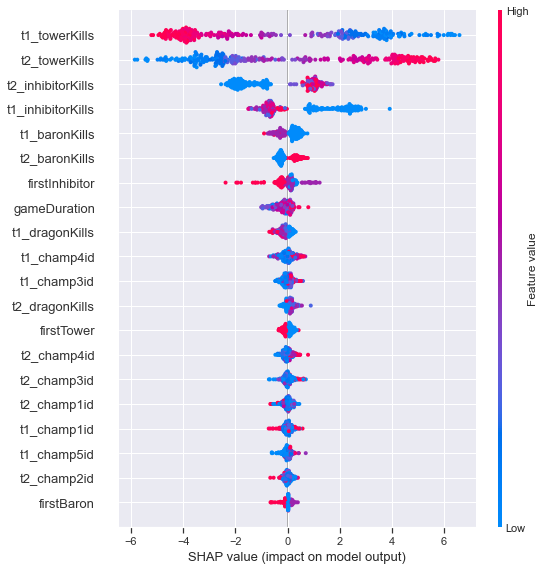

In [252]:
shap_values = explainer.shap_values(X_val.iloc[:300])
shap.summary_plot(shap_values, X_val.iloc[:300])

In [304]:
# towerKills columns are a sort of data leakage, removed it and ran the model again


X_train.drop(['t1_towerKills', 't2_towerKills', 't2_inhibitorKills', \
              't1_inhibitorKills', 'firstInhibitor'], axis=1, inplace=True)
X_val.drop(['t1_towerKills', 't2_towerKills', 't2_inhibitorKills', \
            't1_inhibitorKills', 'firstInhibitor'], axis=1, inplace=True)

xgb_final2 = XGBClassifier(colsample_bytree=0.6,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, gamma = 5,
              n_estimators=600, scale_pos_weight=1,verbosity=1)

clf2 = xgb_final2.fit(X_train, y_train)
y_pred = clf2.predict(X_val)
print('XGB with tuned parameters')
print(classification_report(y_val, y_pred, target_names=target_names))

[21:26:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB with tuned parameters
              precision    recall  f1-score   support

      team 1       0.87      0.87      0.87      5147
      team 2       0.87      0.87      0.87      5151

    accuracy                           0.87     10298
   macro avg       0.87      0.87      0.87     10298
weighted avg       0.87      0.87      0.87     10298



In [306]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_final2, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[21:28:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7ff890bd0890>,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.6, gamma=5,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=5, min_child_weight=5,
                                           missing=nan,
                                           monotone_constr...
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subsampl

In [315]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

In [316]:
xgb_best = random_search.best_estimator_

In [317]:
y_pred = xgb_best.predict(X_val)
print('XGB with tuned parameters')
print(classification_report(y_val, y_pred, target_names=target_names))

XGB with tuned parameters
              precision    recall  f1-score   support

      team 1       0.86      0.86      0.86      5147
      team 2       0.86      0.86      0.86      5151

    accuracy                           0.86     10298
   macro avg       0.86      0.86      0.86     10298
weighted avg       0.86      0.86      0.86     10298



In [309]:
row = X_val.iloc[[1]]
row

,gameDuration,firstBlood,firstTower,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,...,t1_assassin,t1_mage,t1_support,t1_marksman,t2_tank,t2_fighter,t2_assassin,t2_mage,t2_support,t2_marksman
17209,1637,1,1,1,1,1,33,4,12,8,...,1,2,1,0,1,1,1,4,1,0


In [310]:
explainer2 = shap.TreeExplainer(clf2)
shap_values = explainer2.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)


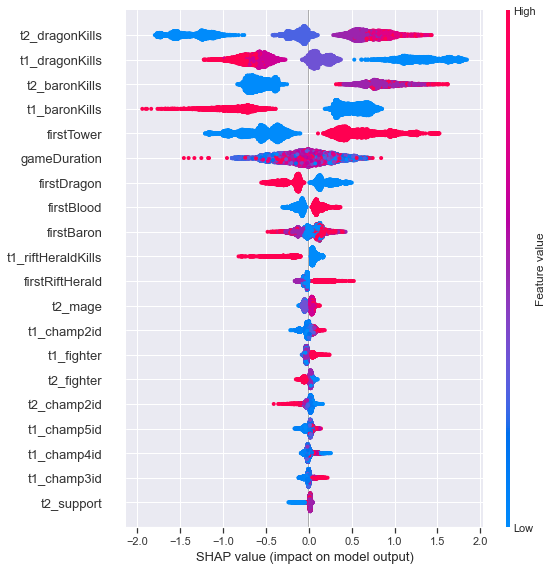

In [311]:
shap_values = explainer2.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

In [479]:
t1_wins = lol_df[lol_df['winner']==1]

In [362]:
t1_tags = t1_wins[['t1_tank', 't1_fighter','t1_mage','t1_support','t1_assassin']].sum()
t1_tags

t1_tank        29939
t1_fighter     56954
t1_mage        43759
t1_support     30227
t1_assassin    42010
dtype: int64

In [363]:
t2_tags = t1_wins[['t2_tank', 't2_fighter','t2_mage','t2_support','t2_assassin']].sum()
t2_tags

t2_tank        29637
t2_fighter     57346
t2_mage        43547
t2_support     30306
t2_assassin    41313
dtype: int64

In [323]:
t1_tags.dtype

dtype('int64')

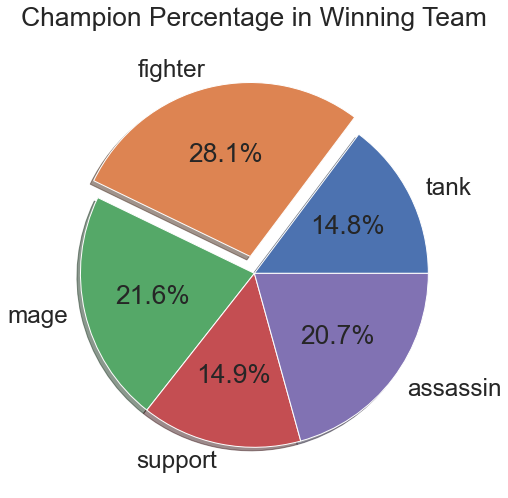

In [417]:

plt.figure(figsize=(8,8))
plt.title('Champion Percentage in Winning Team', pad=30)
labels = ['tank', 'fighter', 'mage', 'support', 'assassin']
plt.pie(t1_tags, explode=(0, 0.1, 0, 0, 0), labels=labels, autopct='%1.1f%%',
        shadow=True);
plt.fontsize=10


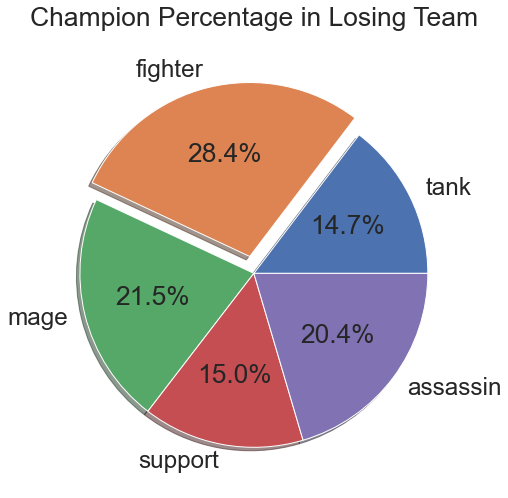

In [418]:

plt.figure(figsize=(8,8))
plt.title('Champion Percentage in Losing Team', pad=30)
labels = ['tank', 'fighter', 'mage', 'support', 'assassin']
plt.pie(t2_tags, explode=(0, 0.1, 0, 0, 0), labels=labels, autopct='%1.1f%%',
        shadow=True);
plt.fontsize=10


In [419]:
print(sorted(tags_df['t1'][0]))

['Assassin', 'Fighter', 'Mage', 'Mage', 'Mage', 'Mage', 'Marksman', 'Support', 'Tank']


In [410]:
# get the most frequent champion tag combinations

tags_df['t1_str'] = ''
tags_df['t2_str'] = ''

def list_string(list1):
    str1 = ' '.join(sorted(list1))
    return str1

tags_df['t1_str'] = tags_df['t1'].apply(list_string)
tags_df['t2_str'] = tags_df['t2'].apply(list_string)

In [434]:
merged_info

,tags,name,title
id,,,
1,[Mage],Annie,the Dark Child
2,"[Fighter, Tank]",Olaf,the Berserker
3,"[Tank, Mage]",Galio,the Colossus
4,[Mage],Twisted Fate,the Card Master
5,"[Fighter, Assassin]",Xin Zhao,the Seneschal of Demacia
...,...,...,...
429,[Marksman],Kalista,the Spear of Vengeance
432,"[Support, Mage]",Bard,the Wandering Caretaker
497,[Support],Rakan,The Charmer


In [472]:
summoner_spell_df

,summonerLevel,name,key,description
id,,,,
1,6,Cleanse,SummonerBoost,Removes all disables (excluding suppression an...
3,4,Exhaust,SummonerExhaust,"Exhausts target enemy champion, reducing their..."
4,8,Flash,SummonerFlash,Teleports your champion a short distance towar...
6,1,Ghost,SummonerHaste,Your champion gains increased Movement Speed a...
7,1,Heal,SummonerHeal,Restores 90-345 Health (depending on champion ...
11,10,Smite,SummonerSmite,Deals 390-1000 true damage (depending on champ...
12,6,Teleport,SummonerTeleport,"After channeling for 4.5 seconds, teleports yo..."
13,1,Clarity,SummonerMana,Restores 50% of your champion's maximum Mana. ...
14,10,Ignite,SummonerDot,"Ignites target enemy champion, dealing 70-410 ..."


In [475]:
# change champion ids to champion names

def champidToName(id):
    name = merged_info['name'][id]
    return name

In [476]:
merged_info['name'][8]

'Vladimir'

In [481]:
champids = ['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id',\
           't2_champ1id', 't2_champ2id','t2_champ3id','t2_champ4id', 't2_champ5id']

for col in champids:
    t1_wins[col] = t1_wins[col].apply(champidToName)

In [524]:
t1_champs = t1_wins[['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id']]
t1_champs

,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id
0,Vladimir,Bard,Kog'Maw,Master Yi,Viktor
1,Draven,Irelia,Nidalee,Kayle,Shaco
2,Tristana,Kayn,Nami,Rumble,Kassadin
3,Maokai,Brand,Twitch,Orianna,Dr. Mundo
4,Warwick,Twitch,Janna,Draven,Syndra
...,...,...,...,...,...
51472,Gnar,Nocturne,Draven,Rakan,Taliyah
51476,Xayah,Leona,Akali,Irelia,Shaco
51479,Jinx,Rakan,Gangplank,Zed,Sejuani
51481,Evelynn,Gragas,Xin Zhao,Jinx,Lissandra


In [525]:
t2_champs = t1_wins[['t2_champ1id', 't2_champ2id','t2_champ3id','t2_champ4id', 't2_champ5id']]
t2_champs

,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id
0,Graves,Xayah,Darius,Zed,Thresh
1,Malphite,Morgana,Hecarim,Yasuo,Riven
2,Cassiopeia,Thresh,Jayce,Jax,Ashe
3,Malzahar,Warwick,Thresh,Riven,Ashe
4,Sona,Jarvan IV,Kayn,Kassadin,Caitlyn
...,...,...,...,...,...
51472,Ashe,Jarvan IV,Soraka,Olaf,Orianna
51476,Urgot,Jarvan IV,Thresh,Heimerdinger,Jinx
51479,Vladimir,Malphite,Caitlyn,Gragas,Blitzcrank
51481,Vladimir,Kayn,Anivia,Morgana,Tristana


In [526]:
for col in t1_champs.columns:
    t1_champs[col] = t1_champs[col].str.lower()

for col in t2_champs.columns:
    t2_champs[col] = t2_champs[col].str.lower()

In [527]:
t1_champs['combined'] = t1_champs.values.tolist()

In [535]:
t2_champs['combined'] = t2_champs.values.tolist()

In [540]:
t1_champs['combined'] = t1_champs['combined'].sort_values().apply(lambda x : sorted(x))

In [541]:
t2_champs['combined'] = t2_champs['combined'].sort_values().apply(lambda x : sorted(x))

In [542]:
t1_champs['combined'].value_counts()

[blitzcrank, kindred, kog'maw, renekton, tristana]    3
[dr. mundo, kayn, orianna, rakan, xayah]              3
[kha'zix, leona, lux, sivir, swain]                   3
[kayn, lissandra, miss fortune, rek'sai, taric]       3
[jarvan iv, jinx, master yi, thresh, yorick]          3
                                                     ..
[ahri, jayce, jhin, lee sin, zyra]                    1
[darius, jax, jinx, morgana, viktor]                  1
[ashe, kha'zix, rakan, thresh, vayne]                 1
[lulu, malphite, orianna, tryndamere, vayne]          1
[annie, janna, kindred, talon, tristana]              1
Name: combined, Length: 25803, dtype: int64

In [543]:
t2_champs['combined'].value_counts()

[lee sin, nami, swain, tristana, zed]              3
[jarvan iv, maokai, rakan, twisted fate, xayah]    3
[blitzcrank, jax, jhin, master yi, shaco]          3
[ezreal, lulu, orianna, thresh, twitch]            3
[diana, draven, janna, master yi, trundle]         3
                                                  ..
[ekko, rakan, rammus, tristana, yasuo]             1
[draven, evelynn, leblanc, maokai, zyra]           1
[blitzcrank, irelia, jarvan iv, syndra, varus]     1
[caitlyn, renekton, syndra, thresh, warwick]       1
[irelia, janna, jhin, malzahar, wukong]            1
Name: combined, Length: 25820, dtype: int64

In [559]:
t1_champs['combined'].reset_index(drop=True, inplace=True)
t2_champs['combined'].reset_index(drop=True, inplace=True)

In [ ]:
# Tried to find frequent combinations that lead to - winning or losing
# 의외로 유난히 눈에 띄는 조합은 없었다. 

In [579]:
t1champs_only = []

for i in range(len(t1_champs)):
    t1champs_only.extend(t1_champs['combined'][i])

In [580]:
t2champs_only = []

for i in range(len(t2_champs)):
    t2champs_only.extend(t2_champs['combined'][i])

In [584]:
from collections import Counter
t1champs_counter = Counter(t1champs_only)
t2champs_counter = Counter(t2champs_only)

In [ ]:
# get most frequent champion combinations

In [594]:
t1_top10 = t1champs_counter.most_common()[:10][:]
t1_top10

[('tristana', 3421),
 ('thresh', 3078),
 ('vayne', 2772),
 ('janna', 2614),
 ('kayn', 2491),
 ('twitch', 2380),
 ('lee sin', 2181),
 ('jinx', 2109),
 ('yasuo', 1996),
 ('jhin', 1986)]

In [595]:
t2_top10 = t2champs_counter.most_common()[:10][:]
t2_top10

[('thresh', 3472),
 ('tristana', 3206),
 ('vayne', 2621),
 ('kayn', 2615),
 ('lee sin', 2500),
 ('lucian', 2215),
 ('jhin', 2123),
 ('twitch', 2115),
 ('xayah', 2047),
 ('yasuo', 1985)]

In [627]:
t2_top10_df = pd.DataFrame(t2_top10)
t2_top10_df

,0,1
0,thresh,3472
1,tristana,3206
2,vayne,2621
3,kayn,2615
4,lee sin,2500
5,lucian,2215
6,jhin,2123
7,twitch,2115
8,xayah,2047
9,yasuo,1985


In [693]:
t1_common = pd.DataFrame(t1champs_counter.most_common())
t2_common = pd.DataFrame(t2champs_counter.most_common())

In [782]:
t_common_df = pd.merge(t1_common, t2_common, how='inner', on=0)

In [783]:
len(t_common_df), len(t1_common)

(138, 138)

In [784]:
t_common_df

,0,1_x,1_y
0,tristana,3421,3206
1,thresh,3078,3472
2,vayne,2772,2621
3,janna,2614,1917
4,kayn,2491,2615
...,...,...,...
133,karthus,239,258
134,ryze,218,287
135,aurelion sol,204,200
136,aatrox,183,203


In [800]:
t_common10 =  t_common_df[:10]
t_common10.columns = ['champions', 'frequency in team 1', 'frequency in team 2']

In [789]:
import plotly.express as px

In [801]:
t_common10

,champions,frequency in team 1,frequency in team 2
0,tristana,3421,3206
1,thresh,3078,3472
2,vayne,2772,2621
3,janna,2614,1917
4,kayn,2491,2615
5,twitch,2380,2115
6,lee sin,2181,2500
7,jinx,2109,1901
8,yasuo,1996,1985
9,jhin,1986,2123


In [807]:
fig = px.bar(t_common10, title='Champion Frequency in Winning Team (2017)', x='champions', y='frequency in team 1', color='champions')
fig.show()

In [809]:
fig = px.bar(t_common10, title='Champion Frequency in Losing Team (2017)', x='champions', y='frequency in team 2', color='champions')
fig.show()

In [763]:
fig = px.bar(t_common_df[:10], x=0, y=1, color=0)
fig.show()

In [765]:
t_common_df[t_common_df[0]=='tristana']

,0,1
0,tristana,3421
1,tristana,3206


In [766]:
t_common_df.sort_values(by=0)

,0,1
135,aatrox,203
136,aatrox,183
23,ahri,1515
15,ahri,1702
76,akali,734
...,...,...
85,ziggs,613
122,zilean,365
121,zilean,364
87,zyra,603


In [774]:
t_common_df.sort_values(by=[1, 0], ascending=False)

,0,1
0,thresh,3472
0,tristana,3421
1,tristana,3206
1,thresh,3078
2,vayne,2772
...,...,...
135,aatrox,203
136,aurelion sol,200
136,aatrox,183
137,skarner,143


In [811]:
t_common_df[:10]

,0,1_x,1_y
0,tristana,3421,3206
1,thresh,3078,3472
2,vayne,2772,2621
3,janna,2614,1917
4,kayn,2491,2615
5,twitch,2380,2115
6,lee sin,2181,2500
7,jinx,2109,1901
8,yasuo,1996,1985
9,jhin,1986,2123


In [817]:
fig = px.bar(t_common_df[:10], x=0, y=['1_x', '1_y'], color=0
             )
fig.show()